# Matrix Completion: From Classical SVD to Real-World Applications

This notebook presents the research I conducted as part of the **David H. Blackwell Summer Scholars Program (Summer 2025)** under the mentorship of **Professor Jingbo Liu** at the University of Illinois Urbana-Champaign.

The goal of this project was to explore matrix completion techniques — methods used to recover missing entries in user–item interaction data — which are central to recommendation systems.

We begin with a small toy example to develop intuition, then apply Singular Value Decomposition (SVD) to the MovieLens 100K dataset. Finally, we evaluate reconstruction performance using RMSE and reflect on limitations that motivate more advanced approaches like neural networks and transformers.



# Classical Matrix Completion Techniques
### Using Singular Value Decomposition (SVD) on Small-Scale Toy Data

In this section, we simulate a small user–item ratings matrix with missing values (represented as NaN).
This helps us understand how classical matrix completion works using low-rank assumptions.

We will:
- Fill missing values using item-wise mean imputation
- Apply Singular Value Decomposition (SVD)
- Reconstruct the original matrix
- Evaluate how well SVD performs using RMSE on the known entries

#### Step 1: Filling Missing Values

SVD cannot be applied directly to a matrix with NaN values.
To handle this, we first fill missing values with the mean of each column (i.e., item).
This is a simple baseline imputation strategy that lets us proceed with SVD.

In [17]:

# Create a dummy user-item rating matrix
# NaN represents missing ratings
ratings = pd.DataFrame([
    [5, 3, np.nan, 1],
    [4, np.nan, np.nan, 1],
    [1, 1, np.nan, 5],
    [1, np.nan, np.nan, 4],
    [np.nan, 1, 5, 4]
], columns=["Item1", "Item2", "Item3", "Item4"], index=["User1", "User2", "User3", "User4", "User5"])

# Display the original ratings matrix
ratings

,Item1,Item2,Item3,Item4
User1,5.0,3.0,NaN,1
User2,4.0,NaN,NaN,1
User3,1.0,1.0,NaN,5
User4,1.0,NaN,NaN,4
User5,NaN,1.0,5.0,4


In [18]:
# Step 2: Fill missing values with column-wise (item-wise) mean
# This is a simple imputation method to allow SVD to run
filled_ratings = ratings.fillna(ratings.mean())

# Display the filled matrix
filled_ratings

,Item1,Item2,Item3,Item4
User1,5.00,3.000000,5.0,1
User2,4.00,1.666667,5.0,1
User3,1.00,1.000000,5.0,5
User4,1.00,1.666667,5.0,4
User5,2.75,1.000000,5.0,4


#### Step 2: Performing SVD

Singular Value Decomposition (SVD) breaks a matrix `X` into three components:

- `U`: user feature matrix
- `S`: diagonal matrix of singular values
- `Vᵗ`: item feature matrix

This factorization allows us to reconstruct a low-rank approximation of the original matrix.

In [19]:
from numpy.linalg import svd

# Step 3: Convert the filled DataFrame to a NumPy array
X = filled_ratings.values

# Step 4: Perform Singular Value Decomposition (SVD)
# X ≈ U * S * Vt
U, S, Vt = svd(X, full_matrices=False)


#### Step 3: Matrix Reconstruction

We reconstruct the matrix by multiplying the SVD components back together: This gives us a smoothed version of the original matrix, where the missing values have been estimated based on low-rank structure.


In [20]:
# Reconstruct the matrix
reconstructed = np.dot(U, np.dot(np.diag(S), Vt))
reconstructed_df = pd.DataFrame(reconstructed, columns=ratings.columns, index=ratings.index)
reconstructed_df

,Item1,Item2,Item3,Item4
User1,5.00,3.000000,5.0,1.0
User2,4.00,1.666667,5.0,1.0
User3,1.00,1.000000,5.0,5.0
User4,1.00,1.666667,5.0,4.0
User5,2.75,1.000000,5.0,4.0


#### Step 4: Evaluating Reconstruction Quality

We use **Root Mean Squared Error (RMSE)** to evaluate how close our reconstructed values are to the original known ratings.

We only compute RMSE on entries that were **not missing** in the original matrix.

An RMSE of ~0 in this toy example means that our model perfectly reconstructed the known entries.
This is expected because the matrix is very small and has low complexity.


In [21]:
# Step 4: Evaluate reconstruction accuracy (RMSE on known values only)
from sklearn.metrics import mean_squared_error
import numpy as np

mask = ratings.notna().values
true_values = ratings.values[mask].ravel()
predicted_values = reconstructed[mask].ravel()

mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)

print(f"RMSE on known entries: {rmse:.4f}")


RMSE on known entries: 0.0000


#### Step 5: Visualize Input vs Reconstructed

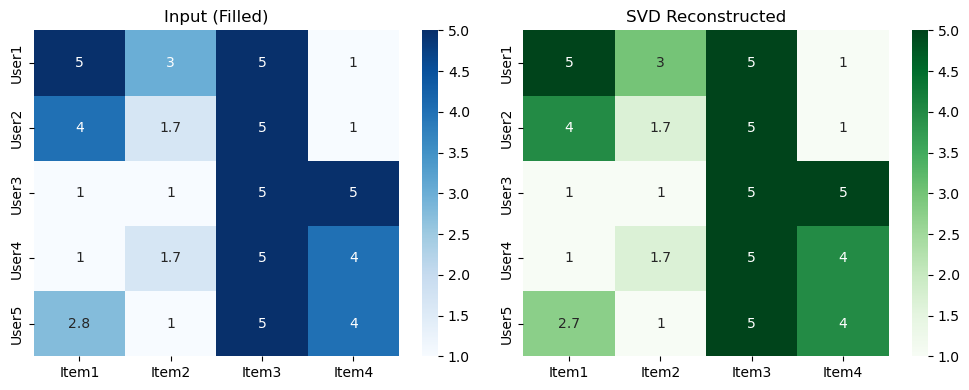

In [22]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(filled_ratings, annot=True, cmap="Blues")
plt.title("Input (Filled)")

plt.subplot(1, 2, 2)
sns.heatmap(reconstructed_df, annot=True, cmap="Greens")
plt.title("SVD Reconstructed")

plt.tight_layout()
plt.show()

### Using Singular Value Decomposition (SVD) on MovieLens 100K Dataset
#### Dataset Exploration 
We now explore the MovieLens 100K dataset — a real-world set of 100,000 user ratings for 1,682 movies by 943 users.

We'll:
- Merge ratings with movie titles
- Visualize popular movies and rating distributions
- Identify highly rated movies with sufficient data

   user_id  item_id  rating  timestamp                       title
0      196      242       3  881250949                Kolya (1996)
1      186      302       3  891717742    L.A. Confidential (1997)
2       22      377       1  878887116         Heavyweights (1994)
3      244       51       2  880606923  Legends of the Fall (1994)
4      166      346       1  886397596         Jackie Brown (1997)
Dataset shape: (100000, 5)
Unique users: 943
Unique movies: 1682

Top 10 most rated movies:
title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64


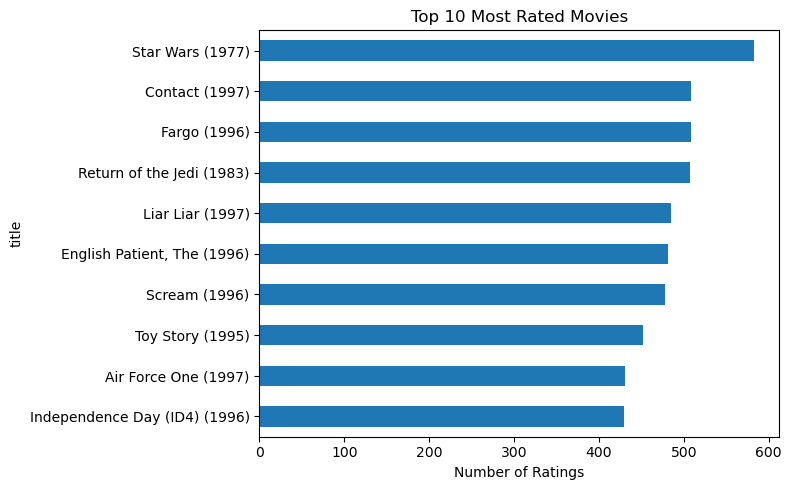

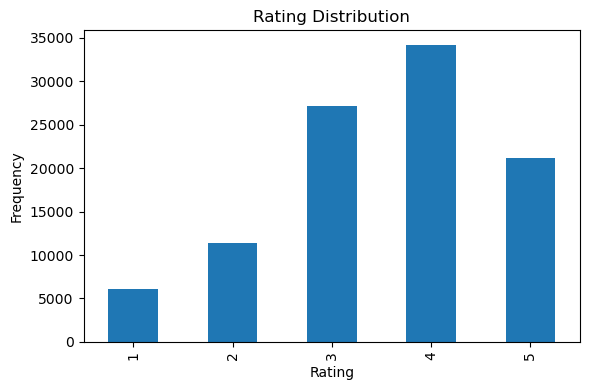


Top 10 highest rated movies (min 50 ratings):
title
Close Shave, A (1995)                                     4.491071
Schindler's List (1993)                                   4.466443
Wrong Trousers, The (1993)                                4.466102
Casablanca (1942)                                         4.456790
Wallace & Gromit: The Best of Aardman Animation (1996)    4.447761
Shawshank Redemption, The (1994)                          4.445230
Rear Window (1954)                                        4.387560
Usual Suspects, The (1995)                                4.385768
Star Wars (1977)                                          4.358491
12 Angry Men (1957)                                       4.344000
Name: rating, dtype: float64


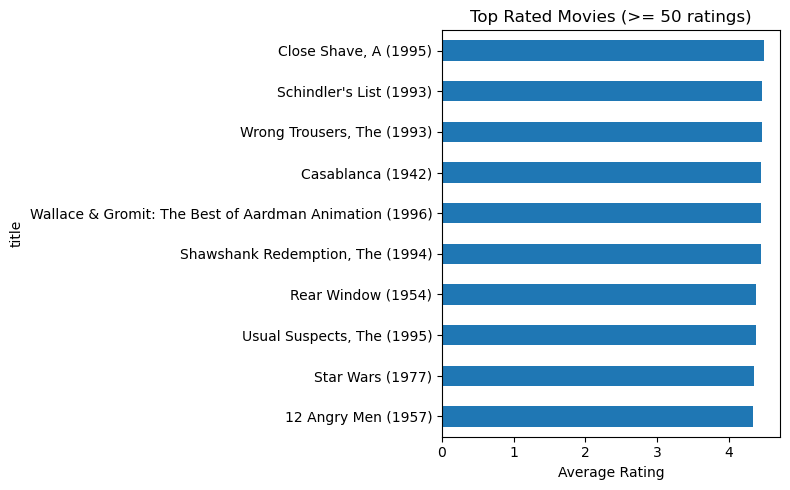

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load the ratings data
ratings = pd.read_csv(
    "/Users/allison.prabakar/Desktop/ml-recommendation-project/ml-100k/u.data",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"]
)

# Step 2: Load the movie titles only
movies = pd.read_csv(
    "/Users/allison.prabakar/Desktop/ml-recommendation-project/ml-100k/u.item",
    sep="|",
    encoding="latin-1",
    header=None,
    usecols=[0, 1],  # Only keep item_id and title
    names=["item_id", "title"]
)

# Step 3: Merge ratings and movie titles into one table
merged = pd.merge(ratings, movies, on="item_id")

# Step 4: See the first few rows
print(merged.head())

# Dataset summary
print("Dataset shape:", merged.shape)
print("Unique users:", merged['user_id'].nunique())
print("Unique movies:", merged['item_id'].nunique())

# Top 10 most rated movies
most_rated = merged['title'].value_counts().head(10)
print("\nTop 10 most rated movies:")
print(most_rated)

most_rated.plot(kind='barh', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.xlabel("Number of Ratings")
plt.title("Top 10 Most Rated Movies")
plt.tight_layout()
plt.show()

# Rating distribution
merged['rating'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6, 4)
)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating Distribution")
plt.tight_layout()
plt.show()

# Top 10 highest-rated movies with at least 50 ratings
avg_ratings = merged.groupby("title")["rating"].mean()
popular_movies = merged['title'].value_counts()
top_avg = avg_ratings[popular_movies >= 50].sort_values(ascending=False).head(10)

print("\nTop 10 highest rated movies (min 50 ratings):")
print(top_avg)

top_avg.plot(kind='barh', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.xlabel("Average Rating")
plt.title("Top Rated Movies (>= 50 ratings)")
plt.tight_layout()
plt.show()



#### Matrix Completion on MovieLens with SVD

We pivot the dataset into a user–item matrix with many missing entries (i.e., not all users rate all movies).

We'll:
- Fill missing ratings using item-wise mean
- Apply truncated SVD
- Reconstruct the matrix
- Evaluate prediction quality using RMSE

#### What Does SVD Really Do Here?
SVD allows us to break down the giant user–movie rating matrix into smaller matrices that capture latent features — hidden dimensions that influence a user’s preferences and a movie’s qualities.

Think of each movie as being described by things like:

- How action-packed it is

- How romantic it is

- How dramatic, comedic, etc.

And each user as having preferences for those same aspects.
SVD finds a way to represent both users and movies in this shared feature space, so we can estimate missing ratings via dot product.

### Matrix Completion using Truncated SVD

After filling missing entries (e.g., using item-wise mean), we apply **Singular Value Decomposition (SVD)** to the user–item rating matrix $R \in \mathbb{R}^{m \times n}$:

$$
R \approx U_k \Sigma_k V_k^T
$$

Where:
- $U_k \in \mathbb{R}^{m \times k}$: user-feature matrix
- $\Sigma_k \in \mathbb{R}^{k \times k}$: diagonal matrix of top $k$ singular values
- $V_k^T \in \mathbb{R}^{k \times n}$: feature-movie matrix


The reconstructed matrix is:

$$
\hat{R} = U_k \Sigma_k V_k^T
$$

---

### Evaluating Reconstruction: RMSE

We compute the **Root Mean Squared Error (RMSE)** between the original known ratings and the reconstructed matrix:

$$
\text{RMSE} = \sqrt{ \frac{1}{|K|} \sum_{(i,j) \in K} (R_{ij} - \hat{R}_{ij})^2 }
$$

Where:
- \( K \) is the set of known (non-missing) ratings in \( R \)


#### Choosing the Number of Components (k) in SVD

The number of latent features we keep — k — controls the balance between simplicity and expressiveness:

Small k: Captures broad trends (e.g., some people like action, others like romance).

Large k: Captures more subtle, nuanced preferences — but risks fitting noise.

To find a good balance, we compute the RMSE (Root Mean Squared Error) between the known ratings and the reconstructed ones for various k values.

The plot below shows how RMSE changes with increasing k. We're often looking for an "elbow point": the spot where adding more complexity doesn't meaningfully improve accuracy.

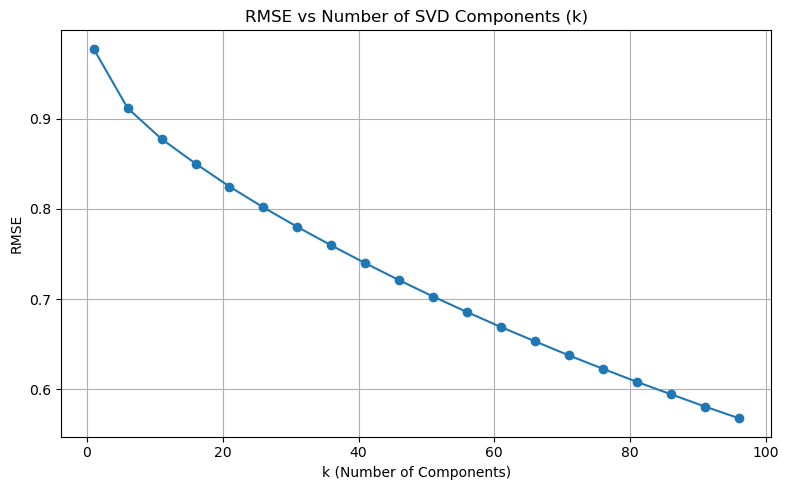

In [24]:

from sklearn.metrics import mean_squared_error


# Create user–item matrix and fill missing values
user_item_matrix = ratings.pivot_table(index="user_id", columns="item_id", values="rating")
filled_matrix = user_item_matrix.apply(lambda col: col.fillna(col.mean()), axis=0)

# Apply SVD
R = filled_matrix.values
U, S, Vt = svd(R, full_matrices=False)
mask = ~np.isnan(user_item_matrix.values)
true_values = user_item_matrix.values[mask]

# Test multiple values of k and compute RMSE
k_values = list(range(1, 101, 5))
rmse_values = []

for k in k_values:
    R_k = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    pred_values = R_k[mask]
    rmse_k = np.sqrt(mean_squared_error(true_values, pred_values))
    rmse_values.append(rmse_k)

# Plot RMSE vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_values, marker='o')
plt.title("RMSE vs Number of SVD Components (k)")
plt.xlabel("k (Number of Components)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations from RMSE vs Number of SVD Components (k)

- The RMSE decreases steadily as the number of components **k** increases, meaning that more latent features help the model better reconstruct the known ratings.
- However, the rate of improvement **slows down after k ≈ 40**, suggesting diminishing returns beyond that point.
- This “elbow” at **k = 40** represents a good trade-off between model complexity and reconstruction accuracy.
- Choosing a k value that is too low underfits the data, while a very high k may risk overfitting or capturing noise.
- Based on this, we select **k = 40** for further experiments.
